#### Inspiration https://github.com/ajhalthor/Time-Series-Forecasting

**Indian Restaurant datatset**: https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders


**Objective**: We want to forecast out order volume for staffing

**Notes**
- Find the number of daily orders
- Using pandasql since it'll be as close to what you'd be doing at work (working with SQL)

In [1]:
#!pip3 install pandasql

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [3]:
#import pandasql
#help (pandasql)

In [4]:
from pandasql import load_births
df= load_births()
print (df.shape)
df.sample(3)

(408, 2)


,date,births
12,1976-01-01,259173
152,1990-11-01,314321
351,2005-08-01,360103


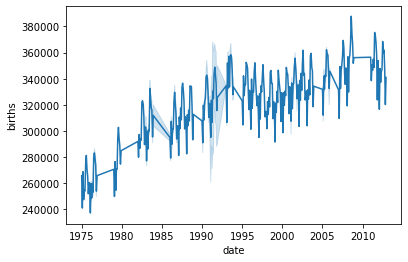

In [5]:
sns.lineplot(x=df.date, y=df.births)

In [6]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [7]:
orders = pd.read_csv('data/restaurant-1-orders.csv')
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']

In [8]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
32453,12142,21/11/2018 22:18,Garlic Rice,2,3.95,5
51932,11951,09/11/2018 19:04,Curry - Chicken Tikka,1,7.95,3


In [9]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [10]:
orders.sample(2) 

,number,timestamp,item,quantity,price,total_products_in_cart,date
54833,15038,25/05/2019 22:15,Paneer Tikka Masala,1,8.95,6,2019-05-25
52301,10328,16/07/2018 20:45,Madras - Chicken,1,7.95,5,2018-07-16


In [11]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


In [12]:
def load_query(path):
    with open(path) as file:
        return file.read()

### Case 1: Direct Multistep Forecasting 

In [13]:
query = load_query('queries/daily_orders.sql')
daily_orders = pysqldf(query)

In [14]:
daily_orders.sample(2)

,date,num_orders
755,2018-05-08,10
384,2017-04-23,7


In [15]:
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Prevent the matplotlib infos on categorical x-axis, removable

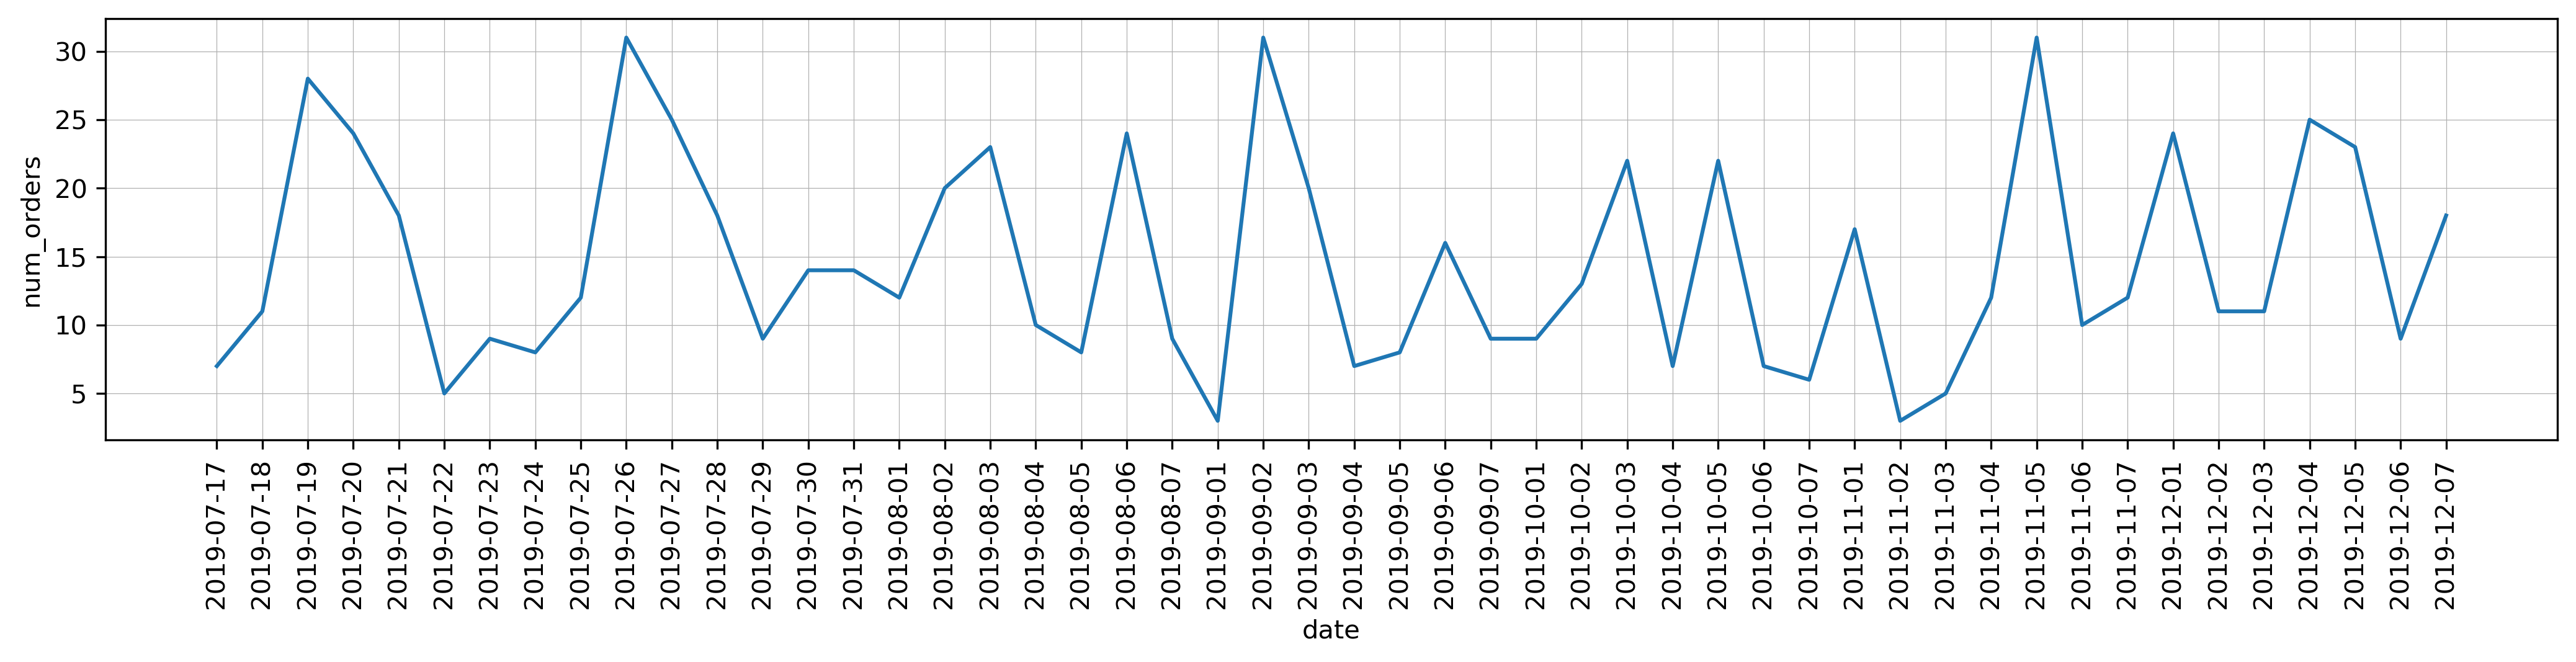

In [16]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Too less orders daily to bother forecasting. Let's look at weekly order volume instead

In [17]:
query = load_query('queries/weekly_orders.sql')
weekly_orders = pysqldf(query)

In [18]:
weekly_orders.sample(2)

,week,num_orders
75,2017-06-12,51
123,2018-05-14,62


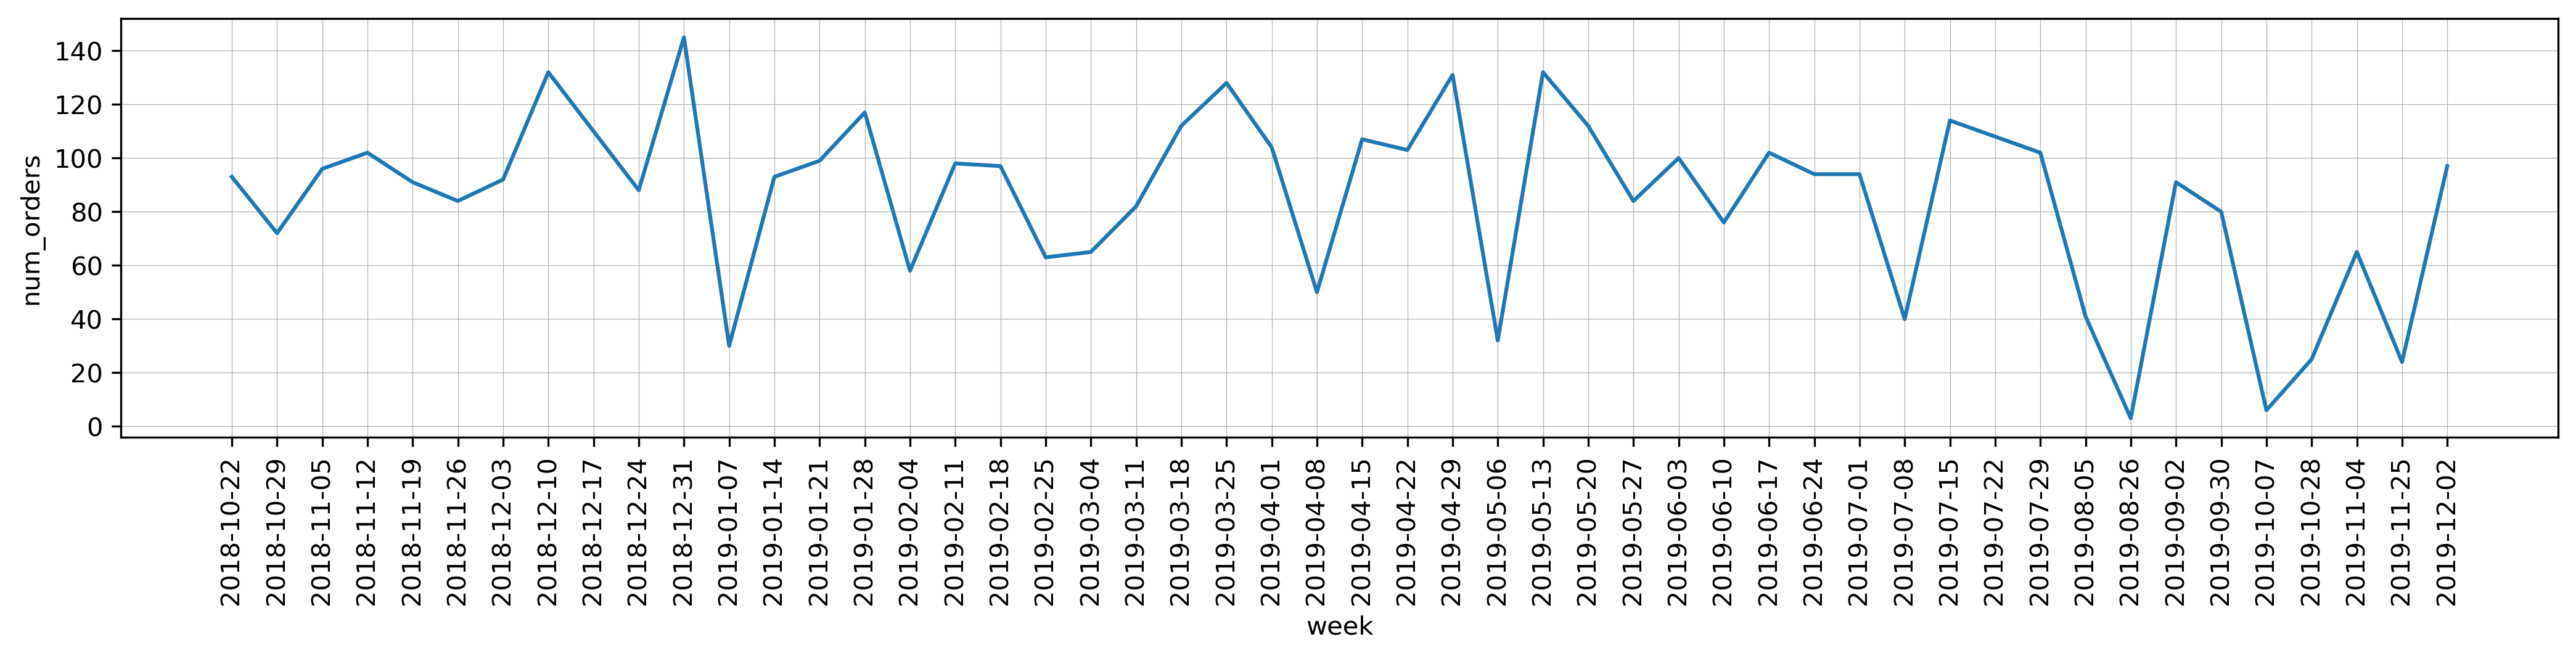

In [19]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [20]:
query = load_query('queries/base.sql')
df = pysqldf(query)
df.to_csv('csvs/dataset.csv')

In [21]:
df.sample(3)

,week,order_count_7_day,order_count_30_day,label
143,2018-11-05,72,408,96
2,2016-02-01,0,57,26
138,2018-10-01,100,421,75


In [22]:
features = ['order_count_7_day', 'order_count_30_day']
label = 'label'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[label]
X_test, y_test = test_df[features], test_df[label]

In [23]:
X_train.shape, X_test.shape

((173, 2), (17, 2))

In [24]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:68.79894	validation_1-mae:72.73834
[1]	validation_0-mae:68.12782	validation_1-mae:72.12849
[2]	validation_0-mae:67.46321	validation_1-mae:71.52456
[3]	validation_0-mae:66.80495	validation_1-mae:70.89914
[4]	validation_0-mae:66.15327	validation_1-mae:70.30690
[5]	validation_0-mae:65.50797	validation_1-mae:69.72041
[6]	validation_0-mae:64.86885	validation_1-mae:69.11307
[7]	validation_0-mae:64.23608	validation_1-mae:68.53793
[8]	validation_0-mae:63.60947	validation_1-mae:67.96839
[9]	validation_0-mae:62.98890	validation_1-mae:67.37857
[10]	validation_0-mae:62.37450	validation_1-mae:66.82005
[11]	validation_0-mae:61.76610	validation_1-mae:66.26696
[12]	validation_0-mae:61.16367	validation_1-mae:65.71925
[13]	validation_0-mae:60.56696	validation_1-mae:65.16514
[14]	validation_0-mae:59.97624	validation_1-mae:64.62994
[15]	validation_0-mae:59.39127	validation_1-mae:64.09996
[16]	validation_0-mae:58.81189	validation_1-mae:63.60182
[17]	validation_0-mae:58.23829	validation

[144]	validation_0-mae:18.93494	validation_1-mae:34.60605
[145]	validation_0-mae:18.79677	validation_1-mae:34.56417
[146]	validation_0-mae:18.66344	validation_1-mae:34.47000
[147]	validation_0-mae:18.53014	validation_1-mae:34.40190
[148]	validation_0-mae:18.40113	validation_1-mae:34.33145
[149]	validation_0-mae:18.26818	validation_1-mae:34.28966
[150]	validation_0-mae:18.14343	validation_1-mae:34.22350
[151]	validation_0-mae:18.01693	validation_1-mae:34.13347
[152]	validation_0-mae:17.89416	validation_1-mae:34.06844
[153]	validation_0-mae:17.77327	validation_1-mae:34.01891
[154]	validation_0-mae:17.65218	validation_1-mae:33.92647
[155]	validation_0-mae:17.53241	validation_1-mae:33.85498
[156]	validation_0-mae:17.41430	validation_1-mae:33.77951
[157]	validation_0-mae:17.29526	validation_1-mae:33.73865
[158]	validation_0-mae:17.18186	validation_1-mae:33.65255
[159]	validation_0-mae:17.06928	validation_1-mae:33.58545
[160]	validation_0-mae:16.95647	validation_1-mae:33.53713
[161]	validati

[286]	validation_0-mae:9.11327	validation_1-mae:30.69511
[287]	validation_0-mae:9.08013	validation_1-mae:30.69747
[288]	validation_0-mae:9.05462	validation_1-mae:30.68137
[289]	validation_0-mae:9.02031	validation_1-mae:30.68040
[290]	validation_0-mae:8.99476	validation_1-mae:30.67139
[291]	validation_0-mae:8.96982	validation_1-mae:30.65571
[292]	validation_0-mae:8.93634	validation_1-mae:30.65611
[293]	validation_0-mae:8.90444	validation_1-mae:30.65788
[294]	validation_0-mae:8.87966	validation_1-mae:30.64931
[295]	validation_0-mae:8.85540	validation_1-mae:30.63399
[296]	validation_0-mae:8.82418	validation_1-mae:30.63466
[297]	validation_0-mae:8.79516	validation_1-mae:30.63337
[298]	validation_0-mae:8.77065	validation_1-mae:30.62850
[299]	validation_0-mae:8.74594	validation_1-mae:30.62148
[300]	validation_0-mae:8.71531	validation_1-mae:30.62154
[301]	validation_0-mae:8.69070	validation_1-mae:30.61323
[302]	validation_0-mae:8.66767	validation_1-mae:30.60568
[303]	validation_0-mae:8.64519	

[430]	validation_0-mae:6.89358	validation_1-mae:30.14274
[431]	validation_0-mae:6.88426	validation_1-mae:30.13830
[432]	validation_0-mae:6.87761	validation_1-mae:30.13816
[433]	validation_0-mae:6.86831	validation_1-mae:30.13381
[434]	validation_0-mae:6.85956	validation_1-mae:30.13055
[435]	validation_0-mae:6.85300	validation_1-mae:30.13051
[436]	validation_0-mae:6.84548	validation_1-mae:30.12680
[437]	validation_0-mae:6.83857	validation_1-mae:30.12240
[438]	validation_0-mae:6.82963	validation_1-mae:30.12190
[439]	validation_0-mae:6.82116	validation_1-mae:30.11883
[440]	validation_0-mae:6.81256	validation_1-mae:30.11838
[441]	validation_0-mae:6.80531	validation_1-mae:30.11679
[442]	validation_0-mae:6.79861	validation_1-mae:30.11260
[443]	validation_0-mae:6.79243	validation_1-mae:30.11285
[444]	validation_0-mae:6.78393	validation_1-mae:30.11220
[445]	validation_0-mae:6.77736	validation_1-mae:30.10994
[446]	validation_0-mae:6.77091	validation_1-mae:30.10592
[447]	validation_0-mae:6.76399	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

**Developer's note**: You might see slight increase in MAE. This XGBRegressor optimizes squared loss by default. There isn't support for MAE since gradient boosting (may) require non-zero second order derivatives. Need to confirm

In [25]:
import numpy as np
test_pred = np.round(reg.predict(X_test),0)

#train_pred = np.round(reg.predict(X_train),0)


D:\Users\admin\anaconda3\envs\timeseries\lib\site-packages\xgboost\data.py:115: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "memory consumption")


In [26]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(test_pred)

#train_df['predictions'] = pd.Series(train_pred)

D:\Users\admin\anaconda3\envs\timeseries\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


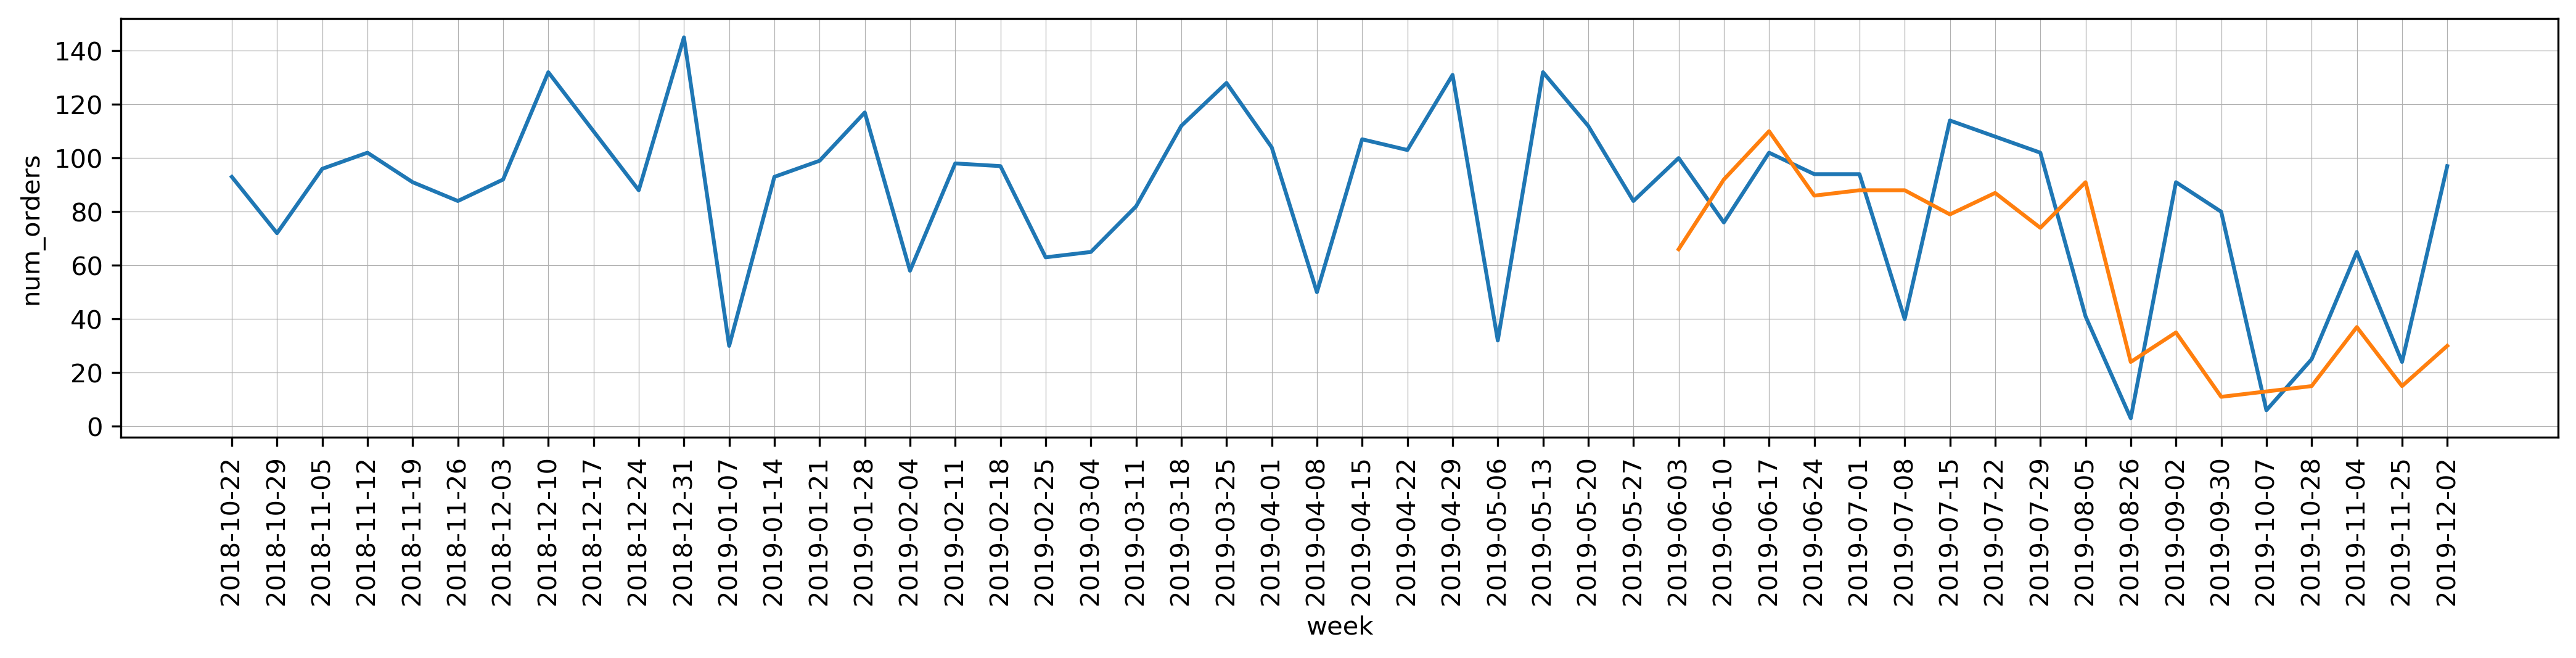

In [55]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

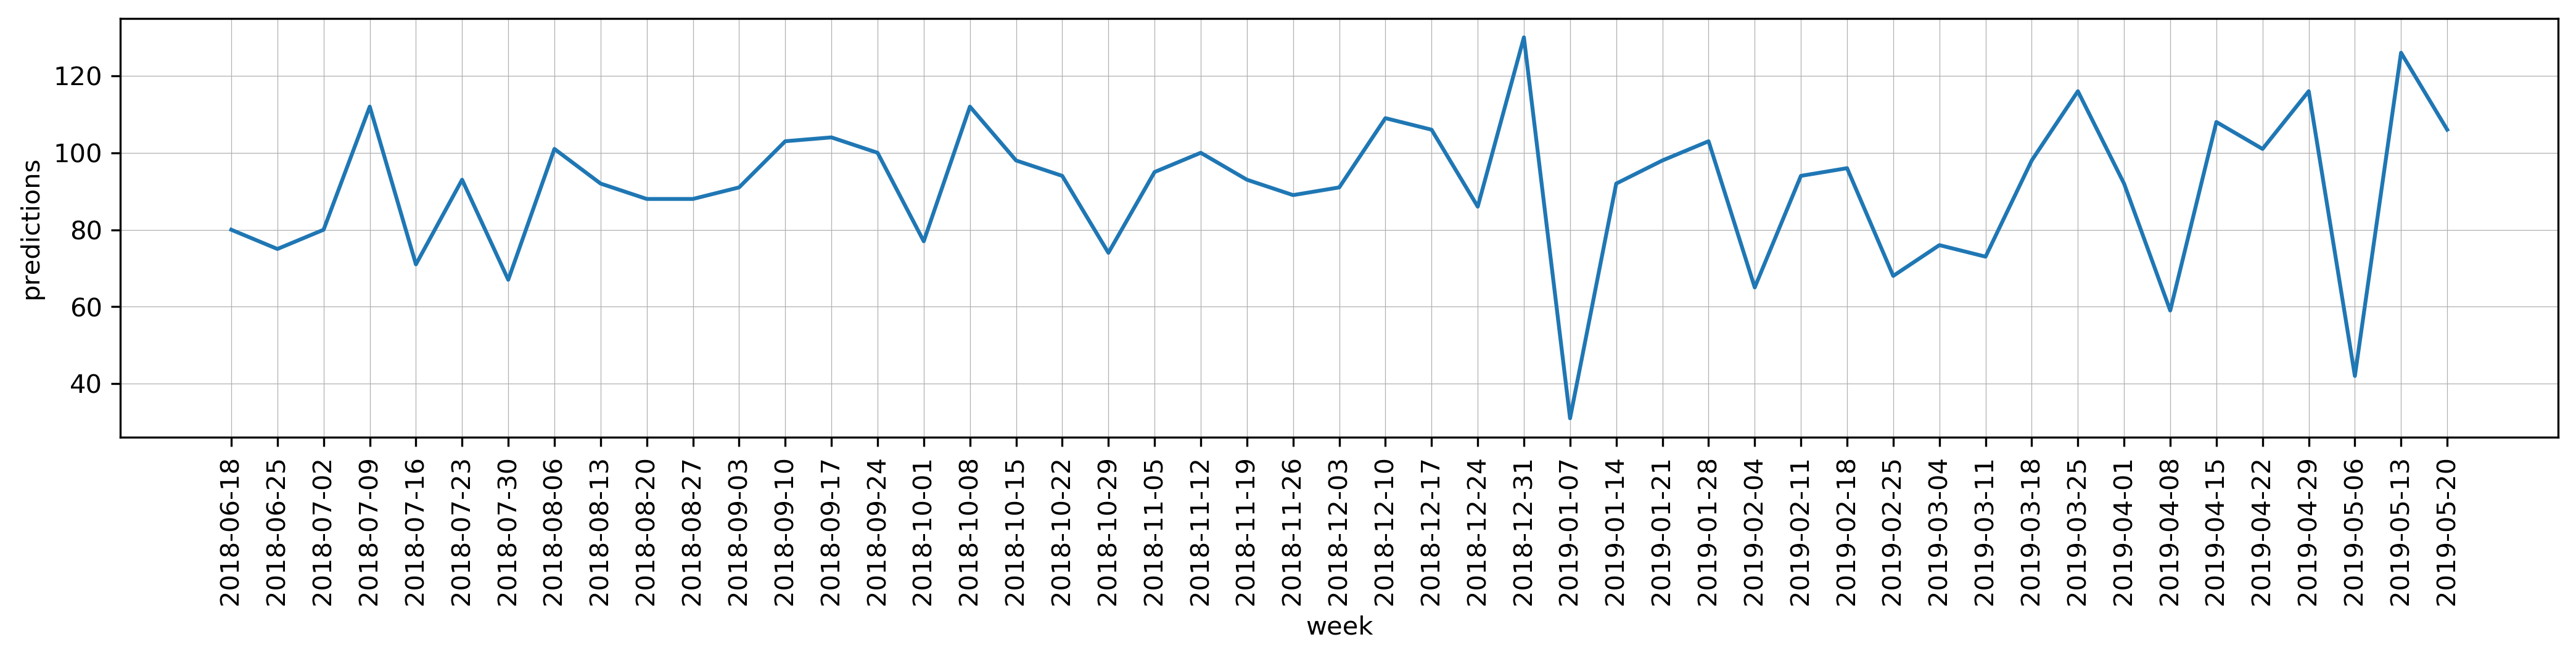

In [53]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=train_df.iloc[-50:-1,:], x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

### Case 2: Prophet

In [30]:
# !pip3 install pystan==2.19.1.1
# !pip3 install fbprophet==0.7.1

In [61]:
from fbprophet import Prophet

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']
train_df_prophet = data[data['ds'] < '2019-06-01']
test_df_prophet = data[data['ds'] >= '2019-06-01']

In [ ]:
data = df[['week', 'label']]
data.columns = ['ds', 'y']

In [ ]:
data.sample(2)

In [ ]:
res = []
for idx in range(173, 190):
    train_df_prophet = data[data.index < idx]
    test_df_prophet = data[data.index == idx]
    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(train_df_prophet)
    prophet_predictions = m.predict(test_df_prophet)
    prophet_predictions['ds'] = prophet_predictions['ds'].apply(lambda x: x.strftime('%Y-%m-%d'))
    result = test_df_prophet.merge(prophet_predictions[['ds', 'yhat']], on='ds')
    res.append(result)

In [ ]:
test_df_prophet = pd.concat(res)

In [ ]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df_prophet, x='ds', y='yhat')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)